# Lab. 6: Bayesian Optimization

## Introduction

#### <u>The goal of this lab is to study the behavior of Bayesian optimization on a regression problem.</u>

Bayesian optimization is a probabilistic approach that uses the Bayes' Theorem $P(A|B) = \frac{P(B|A)*P(A)}{P(B)}$. Briefly, we use the prior information, P(A),(random samples) to optimize a surrogate function, P(B|A).

[Here](https://scikit-learn.org/1.2/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor.predict) you can find the "Gaussian Process Regressor" class documentation.

You'll have to implement some methods:

- *Acquisition Functions*:
  - `USB(args)` Upper Confidence Bound
  $$ \mu(x) + k \sigma(x)  $$
  - `LSB(args)` Lower Confidence Bound (for minimization only)
  $$ \mu(x) - k \sigma(x)  $$
  - `PI(args)` Probability of Improvement
  $$ P(f(x) + k \sigma(x))  $$
  namely
  $$ 1-\Phi(z_0) = \Phi(-z_0) = \Phi(-\frac{f(x^*) + k - \mu(x)}{\sigma(x)}) $$
  where $\Phi$ is the normal cumulative distribution function (hint: use [scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy-stats-norm)).
  - `EI(args)` Expected Improvement
  $$ EI(x) = E[f(x) - f(x_t^+)] $$
  namely
  $$ EI(x) = (\mu(x) - f(x^*) - k)\Phi(\frac{\mu(x) - f(x^*) - k}{\sigma(x)}) + \sigma(x)\varphi(\frac{f(x^*) + k - \mu(x)}{\sigma(x)}) $$
  where $\Phi$ is the normal cumulative distribution function and $\varphi$ is the probability density function (hint: use [scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy-stats-norm))

- *Prior Functions*:
  - `Prior_1(objective_fun, size)` Where `X` is a random array of size `size` and `Y` is the array of `f(x)`.
  - `Prior_2(objective_fun, size)` Where `X` is an array of size `size` of numbers sampled from a uniform distribution `[0.5, 1]` and `Y` is the array of `f(x)`.
  - `Prior_3(objective_fun, size)` Where `X` is an array of size `size` of numbers sampled from a uniform distribution `[0, 0.5]` and `Y` is the array of `f(x)`.
- *Optimization Functions*. Here you can find some examples, feel free to use different functions:
  - `multimodal_1(x)`
  $$ \sin(x) + \sin(\frac{10}{3}x) $$
  - `multimodal_2(x)`
  $$ (1.4-3.0x) \sin(18x) $$
  - `multimodal_3(x)`
  $$ x^2 + \sin(5 \pi x)^6 $$
---

In [1]:
# example of bayesian optimization for a 1d function from scratch
from abc import ABC, abstractmethod
from enum import Enum
from typing import Literal, Optional
from warnings import catch_warnings, simplefilter

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
from numpy.typing import NDArray
from scipy.stats import norm
from sklearn.datasets import make_blobs
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, DotProduct, ExpSineSquared,
                                              Kernel)
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from skopt import gp_minimize
from skopt.space import Integer
from skopt.utils import use_named_args

In [2]:
class AcquisitionFunctionName(Enum):
    UCB = "ucb"
    LCB = "lcb"
    PI = "pi"
    EI = "ei"


class AcquisitionFunction(ABC):
    def __init__(
        self, mu: NDArray[np.float64], std: NDArray[np.float64], best: float, k: float
    ) -> None:
        """
        Abstract class for acquisition functions
        - mu: array of mean values for each sample
        - std: array of standard deviation values for each sample
        - best: best value found so far
        - k: exploration parameter

        """
        self.mu = mu
        self.std = std
        self.best = best
        self.k = k

    @abstractmethod
    def __call__(self) -> NDArray[np.float64]:
        pass


class UCB(AcquisitionFunction):
    """
    Upper Confidence Bound implementation
    - mu: array of mean values for each sample
    - std: array of standard deviation values for each sample
    - best: best value found so far
    - k: exploration parameter

    """

    def __call__(self) -> NDArray[np.float64]:
        return self.mu + self.k * self.std


class LCB(AcquisitionFunction):
    """
    Lower Confidence Bound implementation
    - mu: array of mean values for each sample
    - std: array of standard deviation values for each sample
    - best: best value found so far
    - k: exploration parameter

    """

    def __call__(self) -> NDArray[np.float64]:
        return self.mu - self.k * self.std


class PI(AcquisitionFunction):
    """
    Probability of implementation
    - mu: array of mean values for each sample
    - std: array of standard deviation values for each sample
    - best: best value found so far
    - k: exploration parameter

    """

    def __call__(self) -> NDArray[np.float64]:
        return norm.cdf(-(self.best + self.k - self.mu) / self.std)


class EI(AcquisitionFunction):
    def __init__(
        self, mu: NDArray[np.float64], std: NDArray[np.float64], best: float, k: float
    ) -> None:
        """
        Expected improvement implementation
        - mu: array of mean values for each sample
        - std: array of standard deviation values for each sample
        - best: best value found so far
        - k: exploration parameter

        """
        self.mu = mu
        self.std = std
        self.best = best
        self.k = k

    def __call__(self) -> NDArray[np.float64]:
        return (self.mu - self.best - self.k) * norm.cdf(
            (self.mu - self.best - self.k) / self.std
        ) + self.std * norm.pdf((self.best + self.k - self.mu) / self.std)

In [3]:
class ObjectiveFunctionName(Enum):
    Multimodal_1 = "multimodal_1"
    Multimodal_2 = "multimodal_2"
    Multimodal_3 = "multimodal_3"


class ObjectiveFunction(ABC):
    @abstractmethod
    def __init__(self):
        pass

    @abstractmethod
    def __call__(self, x: NDArray[np.float64]) -> NDArray[np.float64]:
        pass


class Multimodal_1(ObjectiveFunction):
    def __init__(self, noise: float):
        self.noise = noise

    def __call__(self, x: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Implementation of the multimodal function: sin(x) + sin(10/3 * x)
        - x: value to be evaluated

        Returns:
        - y: evaluation of x
        """
        return np.sin(x) + np.sin(10 / 3 * x) + npr.normal(loc=0, scale=self.noise)


class Multimodal_2(ObjectiveFunction):
    def __init__(self, noise: float):
        self.noise = noise

    def __call__(self, x: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Implementation of the multimodal function: (1.4 - 3.0 * x) * sin(18 * x)
        - x: value to be evaluated

        Returns:
        - y: evaluation of x
        """
        return (1.4 - 3.0 * x) * np.sin(18 * x) + npr.normal(loc=0, scale=self.noise)


class Multimodal_3(ObjectiveFunction):
    def __init__(self, noise: float):
        self.noise = noise

    def __call__(self, x: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Implementation of the multimodal function: x^2 + sin(5 * pi * x)^6
        - x: value to be evaluated

        Returns:
        - y: evaluation of x
        """
        return x**2 + np.sin(5 * np.pi * x) ** 6 + npr.normal(loc=0, scale=self.noise)

In [4]:
class PriorName(Enum):
    Prior_1 = "prior_1"
    Prior_2 = "prior_2"
    Prior_3 = "prior_3"


class Prior(ABC):
    @abstractmethod
    def __init__(self, objective_fun: ObjectiveFunction, size: int):
        pass

    @abstractmethod
    def __call__(self) -> tuple[NDArray[np.float64], NDArray[np.float64]]:
        pass


class Prior_1(Prior):
    def __init__(self, objective_fun: ObjectiveFunction, size: int):
        """
        - objective_fun: function that implements the objective function in use
        - size: an Integer that specifies the size of X and Y arrays
        """
        self.objective_fun = objective_fun
        self.size = size

    def __call__(self) -> tuple[NDArray[np.float64], NDArray[np.float64]]:
        """
        Prior implementation, returns a tuple (X, Y), where `X` is a random array of size `size` and `Y` is the array of `f(x)`.

        Returns:
        - X, Y
        """
        sample = npr.random(self.size)
        evaluations = [self.objective_fun(x) for x in sample]
        return sample, np.asarray(evaluations)


class Prior_2(Prior):
    def __init__(self, objective_fun: ObjectiveFunction, size: int):
        """
        - objective_fun: function that implements the objective function in use
        - size: an Integer that specifies the size of X and Y arrays
        """
        self.objective_fun = objective_fun
        self.size = size

    def __call__(self) -> tuple[NDArray[np.float64], NDArray[np.float64]]:
        """
        Prior implementation, returns a tuple (X, Y), where `X` is an array of size `size` of numbers sampled from a uniform distribution `[0.5, 1]` and `Y` is the array of `f(x)`.

        Returns:
        - X, Y
        """
        sample = npr.uniform(0.5, 1, self.size)
        evaluations = [self.objective_fun(x) for x in sample]
        return sample, np.asarray(evaluations)


class Prior_3(Prior):
    def __init__(self, objective_fun: ObjectiveFunction, size: int):
        """
        - objective_fun: function that implements the objective function in use
        - size: an Integer that specifies the size of X and Y arrays
        """
        self.objective_fun = objective_fun
        self.size = size

    def __call__(self) -> tuple[NDArray[np.float64], NDArray[np.float64]]:
        """
        Prior implementation, returns a tuple (X, Y), where `X` is an array of size `size` of numbers sampled from a uniform distribution `[0, 0.5]` and `Y` is the array of `f(x)`.

        Returns:
        - X, Y
        """
        sample = npr.uniform(0, 0.5, self.size)
        evaluations = [self.objective_fun(x) for x in sample]
        return sample, np.asarray(evaluations)

In [5]:
class BayesianOptimization:
    def __init__(
        self,
        generation: int,
        size: int,
        acquisition_function: AcquisitionFunctionName,
        objective_fun: ObjectiveFunctionName,
        prior: PriorName,
        noise: float = 0.1,
        kernel: Optional[Kernel] = None,
        k: float = 0,
    ) -> None:
        self.generation = generation
        self.size = size

        self._acquisition_function_name = acquisition_function
        # self._acquisition_function(acquisition_function, mu, std, best, k)

        match objective_fun:
            case ObjectiveFunctionName.Multimodal_1:
                self.objective_fun = Multimodal_1(noise)
            case ObjectiveFunctionName.Multimodal_2:
                self.objective_fun = Multimodal_2(noise)
            case ObjectiveFunctionName.Multimodal_3:
                self.objective_fun = Multimodal_3(noise)
            case _:  # type: ignore
                raise ValueError("Invalid objective function")

        match prior:
            case PriorName.Prior_1:
                self.prior = Prior_1(self.objective_fun, size)
            case PriorName.Prior_2:
                self.prior = Prior_2(self.objective_fun, size)
            case PriorName.Prior_3:
                self.prior = Prior_3(self.objective_fun, size)
            case _: # type: ignore
                raise ValueError("Invalid prior")

        self.model = GaussianProcessRegressor(kernel)
        self.k = k

    def __call__(self) -> tuple[NDArray[np.float64], NDArray[np.float64]]:
        # sample the domain sparsely with noise
        x, y = self.prior.__call__()

        # reshape into rows and cols
        x = x.reshape(len(x), 1)
        y = y.reshape(len(y), 1)

        # fit the model
        self.model.fit(x, y)
        # perform the optimization process
        for _ in range(self.generation):
            # select the next point to sample
            x_p = self._acquisition_optimization(x, y)
            # sample the point
            actual = self.objective_fun(x_p)
            # summarize the finding
            _, _ = self.surrogate(np.array([[x_p]]))
            # add the data to the dataset
            x = np.vstack((x, [[x_p]]))
            y = np.vstack((y, [[actual]]))
            # update the model
            self.model.fit(x, y)
        return x, y

    # surrogate or approximation for the objective function
    def surrogate(
        self, X: NDArray[np.float64]
    ) -> tuple[NDArray[np.float64], NDArray[np.float64]]:
        # catch any warning generated when making a prediction
        with catch_warnings():
            # ignore generated warnings
            simplefilter("ignore")
            return self.model.predict(X, return_std=True)  # type: ignore

    # plot real observations vs surrogate function
    def plot(self, X: NDArray[np.float64], y: NDArray[np.float64]):
        ax: plt.Axes
        _, ax = plt.subplots(1, 1)

        # scatter plot of inputs and real objective function
        ax.scatter(X[: self.size], y[: self.size], marker="^")
        ax.scatter(X[self.size :], y[self.size :])
        # line plot of surrogate function across domain5
        Xsamples = np.asarray(np.arange(0, 1, 0.001))
        Xsamples = Xsamples.reshape(len(Xsamples), 1)
        ysamples, _ = self.surrogate(Xsamples)
        ax.plot(Xsamples, ysamples)
        #plot real objective function with noise
        # Xsamples = np.asarray(np.arange(0, 1, 0.001))
        # Xsamples = Xsamples.reshape(len(Xsamples), 1)
        # ysamples = np.asarray([self.objective_fun(x) for x in Xsamples])
        # ax.plot(Xsamples, ysamples)
        
        ax.legend(["Surrogate Points", "Real Points", "Surrogate Function"])
        plt.show()

    # create the acquisition function
    def _acquisition_function(
        self,
        function: AcquisitionFunctionName,
        mu: NDArray[np.float64],
        std: NDArray[np.float64],
        best: float,
        k: float,
    ) -> NDArray[np.float64]:
        match function:
            case AcquisitionFunctionName.UCB:
                self.acquisition_function = UCB(mu, std, best, k)
            case AcquisitionFunctionName.LCB:
                self.acquisition_function = LCB(mu, std, best, k)
            case AcquisitionFunctionName.PI:
                self.acquisition_function = PI(mu, std, best, k)
            case AcquisitionFunctionName.EI:
                self.acquisition_function = EI(mu, std, best, k)
            case _: # type: ignore
                raise ValueError("Invalid acquisition function")

        return self.acquisition_function.__call__()

    def _acquisition_optimization(
        self, X: NDArray[np.float64], y: NDArray[np.float64]
    ) -> NDArray[np.float64]:
        # random search, generate random samples
        Xsamples = npr.random(self.size)
        Xsamples = Xsamples.reshape(len(Xsamples), 1)

        # calculate the best surrogate score found so far
        yhat, _ = self.surrogate(X)
        best = max(yhat)
        # calculate the mean and stdev via surrogate function
        mu, std = self.surrogate(y)
        # calculate the probability of improvement
        scores = self._acquisition_function(
            self._acquisition_function_name, mu, std, best, self.k
        )

        # locate the index of the largest scores
        ix = np.argmax(scores)
        return Xsamples[ix, 0]

## Exercises

### Regression
---
#### Questions:
- How does the prior knowledge change the optimization?
- How does the kernel change the optimization? (see here the [kernels](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes))
- How does the acquisition function affect the optimization?

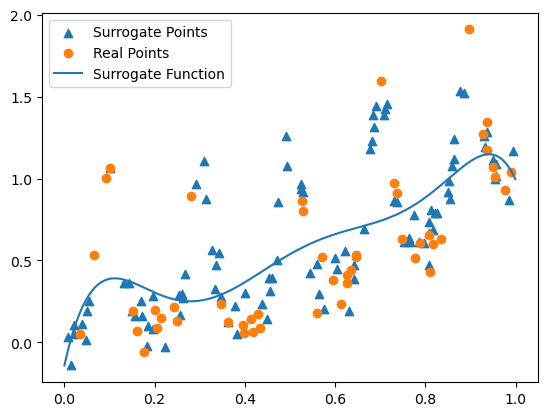

Best Result: x=0.897, y=1.910


In [6]:
size = 100
BO = BayesianOptimization(
    50,
    size,
    AcquisitionFunctionName.UCB,
    ObjectiveFunctionName.Multimodal_3,
    PriorName.Prior_1,
    noise=0.1,
    kernel=None,
    k=0.1,
)  # TODO try with other priors, acquisition functions and objective func
x, y = BO.__call__()
BO.plot(x, y)
# best result
ix = np.argmax(y)
print("Best Result: x=%.3f, y=%.3f" % (x[ix][0], y[ix][0]))

### BONUS

You can now change the acquisition functions in the regression problem, adding a slack variable `k` as a hyperparameter. How does this variable affect the optimization problem?